In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from datasets import load_dataset

ds = load_dataset("ibragim-bad/github-repos-metadata-40M", split="full")
df = ds.to_pandas()

/opt/anaconda3/envs/sb_12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating sample split: 100%|██████████| 1000000/1000000 [00:00<00:00, 3102892.57 examples/s]


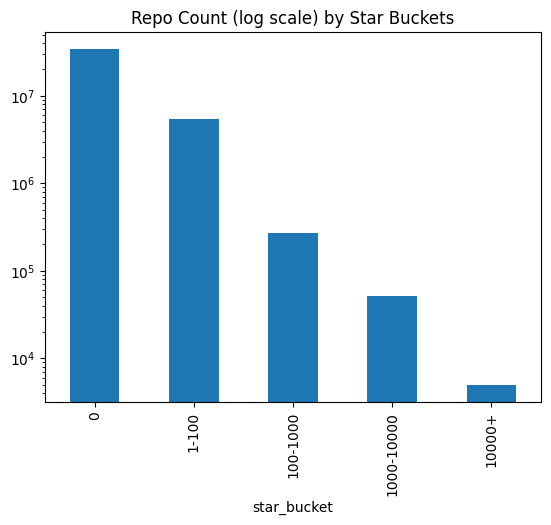

In [2]:
bins = [0, 1, 100, 1000, 10000, float('inf')]
labels = ['0', '1-100', '100-1000', '1000-10000', '10000+']
df['star_bucket'] = pd.cut(df['watchers_count'].fillna(0), bins=bins, labels=labels, right=False)
bucket_counts = df['star_bucket'].value_counts()
bucket_counts.plot(kind='bar')
plt.title('Repo Count (log scale) by Star Buckets')
plt.yscale('log')
plt.show()

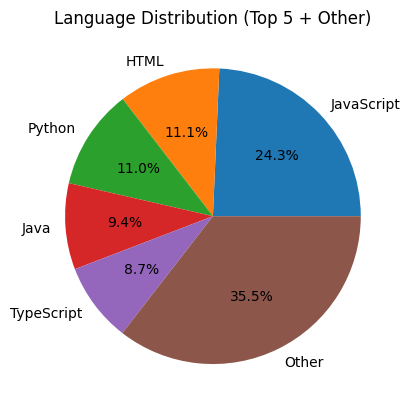

In [5]:
# Top 5 languages + aggregated "Other"

df_lang = df[df['language'].notna()]
top5 = df_lang['language'].value_counts().head(5)
other = int(df_lang['language'].value_counts().iloc[5:].sum())

lang_pie = pd.concat([top5, pd.Series({'Other': other})])
lang_pie.plot(kind='pie', autopct='%1.1f%%')
plt.title('Language Distribution (Top 5 + Other)')
plt.ylabel('')
plt.show()

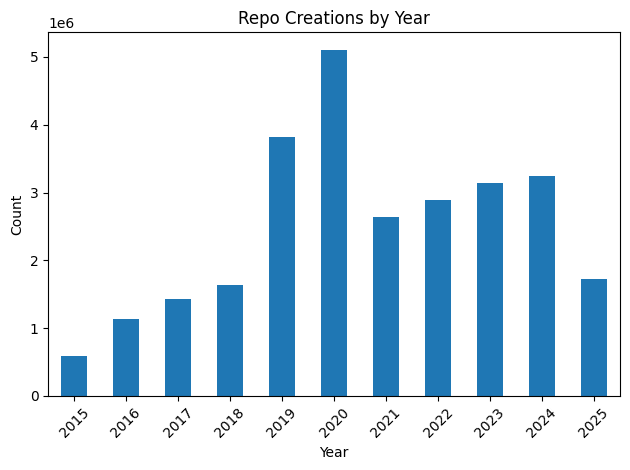

In [6]:
df['year'] = pd.to_datetime(df['created_at'], utc=True, errors='coerce').dt.year.astype('Int64')

year_counts = df['year'].dropna().value_counts().sort_index()
ax = year_counts.plot(kind='bar')
ax.set_title('Repo Creations by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

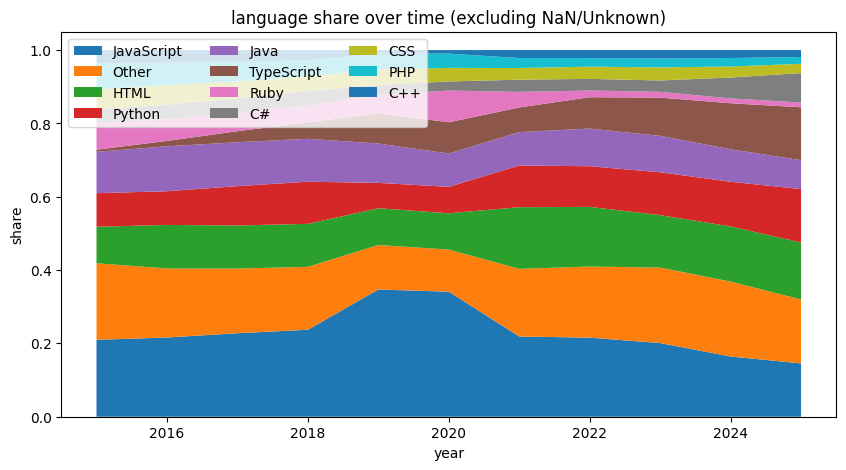

In [7]:
df_lang = df[df['language'].notna() & (df['language'] != 'Unknown')].dropna(subset=['year'])

TOP_LANGS_N = 10

top_langs = df_lang['language'].value_counts().head(TOP_LANGS_N).index.tolist()
lang_year = (
    df_lang.assign(language=lambda x: x['language'].where(x['language'].isin(top_langs), 'Other'))
           .groupby(['year','language'], as_index=False).size()
)

pivot = lang_year.pivot(index='year', columns='language', values='size').fillna(0)
pivot = pivot.div(pivot.sum(axis=1), axis=0)

pivot_sorted_cols = pivot.sum().sort_values(ascending=False).index
pivot = pivot[pivot_sorted_cols]

plt.figure(figsize=(10,5))
plt.stackplot(pivot.index, pivot.T.values, labels=pivot.columns)
plt.title('language share over time (excluding NaN/Unknown)')
plt.xlabel('year'); plt.ylabel('share'); plt.legend(loc='upper left', ncols=3); plt.show()